## Photonic VQE simulations using Qiskit circuits or a parametrized unitary

In [1]:
import perceval as pcvl
import perceval.components as comp
from perceval.algorithm import Sampler

from qlass.utils import loss_function, rotate_qubits
from qlass.vqe import le_ansatz

import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

from scipy.optimize import minimize
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In the following cell, we have a few Hamiltonians from the H2 molecule that we can use to simulate our VQE. The Hamiltonians are obtained from [this paper](https://www.nature.com/articles/ncomms5213).

In [2]:
Hamiltonian_elem = np.load('hamiltonian_elem.npy')

Hamiltonian_coef = np.load('hamiltonian_coef.npy')

# Building the Hamiltonian H[0] = Radius, H[1] = H(Radius)
H1 = []
(n,m) = Hamiltonian_coef.shape
for i in range(n):  # i = Radius
    h_0 = 1.0 * np.matrix(Hamiltonian_elem[0])
    for j in range(1, m):
        h_0 += Hamiltonian_coef[i,j] * np.matrix(Hamiltonian_elem[j])
    H1.append([Hamiltonian_coef[i,0], h_0])

H = H1

E1_th = []
for h in H:
    l0 = np.linalg.eigvals(h[1])
    l0.sort()
    E1_th.append(min(l0))


def hamiltonian_dictionary(h):
    """
    Convert a 2-qubit Hamiltonian from array form to a dictionary.

    Args:
    h (np.ndarray): 2-qubit Hamiltonian in array form

    Returns:
    Dict[str, float]: Dictionary with Pauli string keys and coefficient values
    """
    pauli_strings = ["II", "IX", "IZ", "XI", "XX", "XZ", "ZI", "ZX", "ZZ"]
    return dict(zip(pauli_strings, h))

This is the VQE simulation where we use Qiskit circuits to define the ansatz. We use executors to obtain samples from eiter a quantum simulator of quantum hardware, just like how we use executors in Mitiq. This makes things considerably more modular.

In [3]:
#Executor for a two qubit qiskit ansatz.
def executor(lp, pauli_string):
    processor = le_ansatz(lp, pauli_string)

    sampler = Sampler(processor)
    samples = sampler.samples(10_000)

    return samples

In [4]:
radius1 = []
E1_qiskit = []

num_qubits = 2

for R in tqdm(range(5, 50, 2)):
    h = Hamiltonian_coef[R, 1:]        # All terms except the first
    H = hamiltonian_dictionary(h)      # Custom function, I assume
    radius1.append(Hamiltonian_coef[R, 0])

    initial_params = np.random.rand(2*num_qubits)

    # Finding the ground state energy for each H(R)
    result = minimize(loss_function, initial_params, args=(H, executor), method='COBYLA', options={'maxiter': 30})
    # print(f'number of function evaluations: {result.nfev}')
    E1_qiskit.append(result.get('fun'))

100%|██████████| 23/23 [11:10<00:00, 29.15s/it]


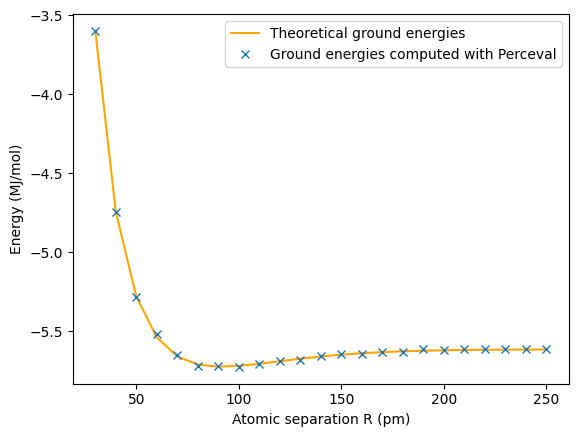

The minimum energy is E_g(1.0)=-5.72691514 MJ/mol and is attained for R_min =1.0 pm


In [5]:
plt.plot(100*np.array(radius1), np.array(E1_th)[range(5, 50, 2)],'orange')
plt.plot(100*np.array(radius1), E1_qiskit,'x')
plt.ylabel('Energy (MJ/mol)')
plt.xlabel('Atomic separation R (pm)')

plt.legend(['Theoretical ground energies', 'Ground energies computed with Perceval'])

plt.show()

min_value=min(E1_qiskit)
min_index = E1_qiskit.index(min_value)
print('The minimum energy is E_g('+str(radius1[min_index])+')='+str(E1_qiskit[min_index])+' MJ/mol and is attained for R_min ='+str(radius1[min_index])+' pm')

In the following cell we define a function that generates arbitrary two qubit unitaries given the parameters. This can be used in a VQE simulation to find ground states of two qubit Hamiltonians.
One can also use a custom function that generates a unitary according to some custom noise model.

In [6]:
import numpy as np
from scipy.linalg import expm
import numpy as np
from scipy.linalg import sqrtm

# Pauli matrices and identity
sigma_0 = np.eye(2, dtype=complex)  # Identity matrix
sigma_1 = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_2 = np.array([[0, -1j], [1j, 0]], dtype=complex)
sigma_3 = np.array([[1, 0], [0, -1]], dtype=complex)

# List of Pauli matrices (including identity)
paulis = [sigma_0, sigma_1, sigma_2, sigma_3]

def construct_unitary_from_parameters(params):
    """
    Constructs a 4x4 unitary matrix from 16 real parameters using the basis Γ(i, j) = σ_i ⊗ σ_j.

    Args:
        params (list or np.ndarray): A list or array of 16 real parameters.

    Returns:
        np.ndarray: A 4x4 unitary matrix.
    """
    if len(params) != 16:
        raise ValueError(f"Exactly 16 parameters are required, but {len(params)} were given.")

    # Reshape the parameters into a 4x4 grid for easier indexing
    params_grid = np.array(params).reshape(4, 4)

    # Initialize the 4x4 Hermitian matrix
    H = np.zeros((4, 4), dtype=complex)

    # Construct the Hermitian matrix H = sum_{i,j} d(i,j) Γ(i,j)
    for i in range(4):
        for j in range(4):
            # Compute Γ(i,j) = σ_i ⊗ σ_j
            gamma_ij = np.kron(paulis[i], paulis[j])
            # Add the term d(i,j) * Γ(i,j) to H
            H += params_grid[i, j] * gamma_ij

    # Construct the unitary matrix U = exp(iH)
    U = expm(1j * H)

    return U

def check_unitarity(U, tolerance=1e-10):
    """Check if a matrix is unitary within given tolerance"""
    I = np.eye(U.shape[0], dtype=U.dtype)
    UHU = U.conj().T @ U
    max_diff = np.max(np.abs(UHU - I))
    return max_diff, max_diff < tolerance

U = construct_unitary_from_parameters(np.random.rand(16))
check_unitarity(U)

(np.float64(4.268970847729488e-16), np.True_)

In [7]:
# Mach-Zehnder interferometer
mzi = comp.BS() // (0, comp.PS(pcvl.Parameter("phi1"))) // comp.BS() // (0, comp.PS(pcvl.Parameter("phi2")))

#Executor for a two qubit unitary.
def executor(lp, pauli_string):

    params = np.concatenate((np.random.rand(11), lp))
    num_qubits = len(pauli_string)

    unitary = construct_unitary_from_parameters(params)
    M = pcvl.Matrix(unitary)
    ansatz = pcvl.Circuit.decomposition(M, mzi, shape=pcvl.InterferometerShape.TRIANGLE)
    ansatz_rot = rotate_qubits(pauli_string, ansatz.copy())
    processor = pcvl.Processor(pcvl.NaiveBackend(), ansatz_rot)

    processor.with_input(pcvl.BasicState([0,1]*num_qubits))

    sampler = Sampler(processor)
    samples = sampler.samples(10_000)

    return samples
executor(np.random.rand(5), 'II')['results'][:10]

[|1,1,0,0>,
 |0,0,0,2>,
 |0,2,0,0>,
 |0,0,0,2>,
 |0,2,0,0>,
 |0,1,1,0>,
 |0,0,0,2>,
 |0,1,0,1>,
 |0,0,0,2>,
 |1,0,1,0>]

We can now start the VQE simulation

In [8]:
radius1 = []
E1 = []


# for R in tqdm(range(5, 50, 2)):  # We try to find the ground state eigenvalue for each radius R

#     h = np.array(Hamiltonian_coef[R])[0][1:]
#     H = hamiltonian_dictionary(h)
#     radius1.append(np.array(Hamiltonian_coef[R])[0][0])

for R in tqdm(range(5, 50, 2)):
    h = Hamiltonian_coef[R, 1:]        # All terms except the first
    H = hamiltonian_dictionary(h)      # Custom function, I assume
    radius1.append(Hamiltonian_coef[R, 0])

    initial_params = np.random.rand(5)

    # Finding the ground state eigen value for each H(R)
    result = minimize(loss_function, initial_params, args=(H, executor), method='COBYLA', options={'maxiter': 20})
    # print(f'number of function evaluations: {result.nfev}')
    E1.append(result.get('fun'))


  0%|          | 0/23 [00:00<?, ?it/s]

100%|██████████| 23/23 [06:39<00:00, 17.36s/it]


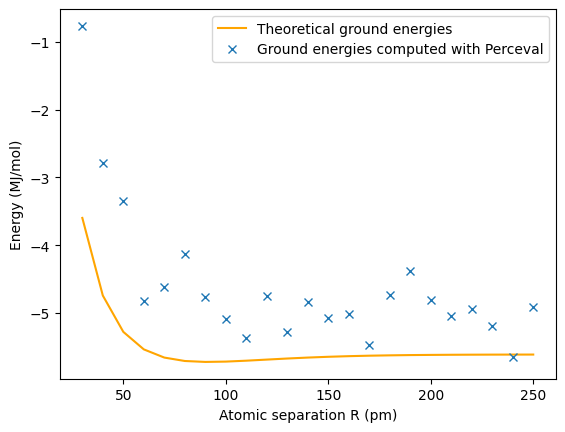

The minimum energy is E_g(2.4)=-5.651872619130003 MJ/mol and is attained for R_min =2.4 pm


In [9]:
plt.plot(100*np.array(radius1), np.array(E1_th)[range(5, 50, 2)],'orange')
plt.plot(100*np.array(radius1), E1,'x')
plt.ylabel('Energy (MJ/mol)')
plt.xlabel('Atomic separation R (pm)')

plt.legend(['Theoretical ground energies', 'Ground energies computed with Perceval'])

plt.show()

min_value=min(E1)
min_index = E1.index(min_value)
print('The minimum energy is E_g('+str(radius1[min_index])+')='+str(E1[min_index])+' MJ/mol and is attained for R_min ='+str(radius1[min_index])+' pm')

Now let us start the calculating the ground state enerygy for LiH molecule and compare it with the exact solution.

In [10]:
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import TwoLocal
from perceval.algorithm import Sampler

from qlass import compile
from qlass.quantum_chemistry import LiH_hamiltonian, brute_force_minimize
from qlass.vqe import VQE, le_ansatz

We define an executor function that uses the linear entangled ansatz

In [11]:
def executor(params, pauli_string):
    processor = le_ansatz(params, pauli_string)
    sampler = Sampler(processor)
    samples = sampler.samples(10_000)
    return samples

We initialize the number of qubits and generate a 2-qubit Hamiltonian for LiH. Please feel free to play with the parameters

In [12]:
num_qubits = 2
hamiltonian = LiH_hamiltonian(num_electrons=2, num_orbitals=1)
    
# Print the Hamiltonian
print("LiH Hamiltonian:")
for pauli_string, coefficient in hamiltonian.items():
    print(f"  {pauli_string}: {coefficient:.4f}")

LiH Hamiltonian:
  II: -0.6643+0.0000j
  IZ: 0.2704+0.0000j
  ZI: 0.2704+0.0000j
  ZZ: 0.1236+0.0000j


We will calculate the exact ground state energy of the LiH molecule for comparison

In [13]:
exact_energy = brute_force_minimize(hamiltonian)
print(f"\nExact ground state energy: {exact_energy:.6f}")


Exact ground state energy: -1.081406+0.000000j


Now, let us initialize and run the VQE solver with the custom executor we defined above

In [15]:
vqe = VQE(
        hamiltonian=hamiltonian,
        executor=executor,
        num_params=2*num_qubits, # Number of parameters in the linear entangled ansatz
    )

print("\nRunning VQE optimization...")
vqe_energy = vqe.run(
    max_iterations=1000,
    verbose=True
    )


Running VQE optimization...
Starting VQE optimization using COBYLA optimizer
Number of qubits: 2
Number of parameters: 4
Optimization complete!
Final energy: -1.081234
Number of iterations: 53


Here we get the optimal parameters and compare with exact solution

In [16]:
optimal_params = vqe.get_optimal_parameters()

comparison = vqe.compare_with_exact(exact_energy)

In [17]:
print(f"\nOptimization complete!")
print(f"Final energy: {vqe_energy:.6f}")
print(f"Optimal parameters: {optimal_params}")
print(f"Number of iterations: {vqe.optimization_result.nfev}")
print(f"Exact ground state energy: {exact_energy:.6f}")
print(f"Energy difference: {comparison['absolute_error']:.6f}")


Optimization complete!
Final energy: -1.081234
Optimal parameters: [1.00353232 1.59691785 2.10143325 1.57537912]
Number of iterations: 53
Exact ground state energy: -1.081406+0.000000j
Energy difference: 0.000171



Plotting convergence history...
Convergence plot saved as 'vqe_convergence.png'


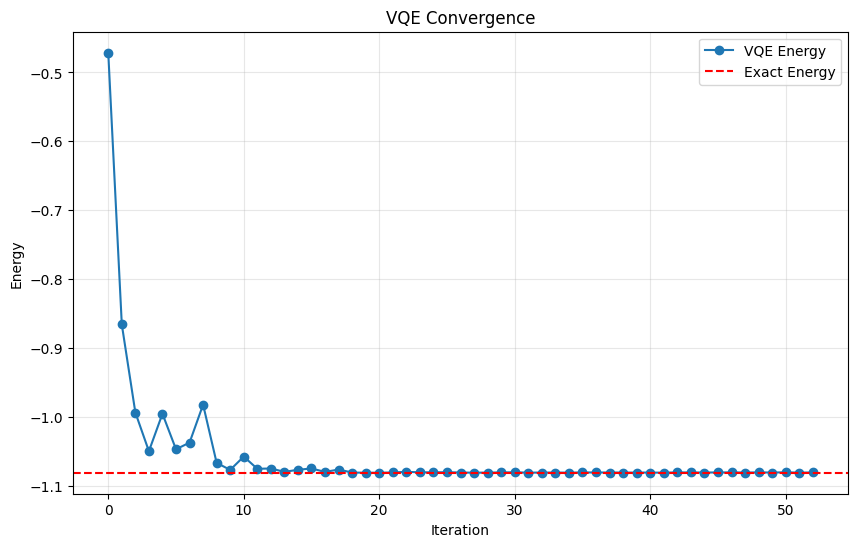

In [18]:
print("\nPlotting convergence history...")
plt.figure(figsize=(10, 6))
iterations = range(len(vqe.energy_history))
plt.plot(iterations, vqe.energy_history, 'o-', label='VQE Energy')
plt.axhline(y=exact_energy, color='r', linestyle='--', label='Exact Energy')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('VQE Convergence')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('vqe_convergence.png')
print("Convergence plot saved as 'vqe_convergence.png'")
